# Neural Net Language models

> Basic neuralnet-based language modeling 

In [79]:
#| default_exp models.lm

Global seed set to 42


In [80]:
#| hide
%load_ext autoreload
%autoreload 2
from nbdev.showdoc import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [81]:
#| export
import torch.nn as nn
import torch
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence
from torch.optim import SGD
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau, ExponentialLR, CosineAnnealingLR
from torch.optim.optimizer import Optimizer

from torch.utils.data import DataLoader
from torchtext.vocab import vocab

import lightning as L
from lightning import Trainer

from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
from tqdm import tqdm

from omegaconf import OmegaConf
from hydra.utils import instantiate

from typing import Dict, List, Tuple, Optional, Set
from collections import Counter, OrderedDict
from dataclasses import dataclass, asdict

from plum import dispatch

from nimrod.text.datasets import CharDataset, Vocab

# N_EPOCHS for training debuggging
ITER_MAX = 5

In [82]:
# reading with pandas
df = pd.read_csv('../data/text/names.txt', header=None, names=['name'])
data = list(df.name)
print("names: ", data[:3])

# reading directly in plain python
lines = []
with open('../data/text/tiny_shakespeare.txt', 'r', encoding='utf-8') as f:
    for line in f.readlines():
        if line.strip():
            # only append non blank lines
            lines.append(line)

# add special tokens
data = [['<bos>'] +list(line.strip()) + ['<eos>'] for line in lines]
print("shakespeare: ", data[:3])

v = Vocab(data)
print(v.stoi('e'))
print(v.itos(8))
print("pad: ", v.stoi('<pad>'))
print(v.stoi(['e','m']))
print(v.itos([8,17]))
print(len(v))
print(''.join(v.vocabulary))

names:  ['emma', 'olivia', 'ava']
shakespeare:  [['<bos>', 'F', 'i', 'r', 's', 't', ' ', 'C', 'i', 't', 'i', 'z', 'e', 'n', ':', '<eos>'], ['<bos>', 'B', 'e', 'f', 'o', 'r', 'e', ' ', 'w', 'e', ' ', 'p', 'r', 'o', 'c', 'e', 'e', 'd', ' ', 'a', 'n', 'y', ' ', 'f', 'u', 'r', 't', 'h', 'e', 'r', ',', ' ', 'h', 'e', 'a', 'r', ' ', 'm', 'e', ' ', 's', 'p', 'e', 'a', 'k', '.', '<eos>'], ['<bos>', 'A', 'l', 'l', ':', '<eos>']]
6
t
pad:  0
[6, 20]
['t', 'l']
70
 !$&',-.3:;<<bos><eos><pad><unk>>?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz


In [83]:
# print first 4 lines of the file
for i in range(4):
    print(data[i])

['<bos>', 'F', 'i', 'r', 's', 't', ' ', 'C', 'i', 't', 'i', 'z', 'e', 'n', ':', '<eos>']
['<bos>', 'B', 'e', 'f', 'o', 'r', 'e', ' ', 'w', 'e', ' ', 'p', 'r', 'o', 'c', 'e', 'e', 'd', ' ', 'a', 'n', 'y', ' ', 'f', 'u', 'r', 't', 'h', 'e', 'r', ',', ' ', 'h', 'e', 'a', 'r', ' ', 'm', 'e', ' ', 's', 'p', 'e', 'a', 'k', '.', '<eos>']
['<bos>', 'A', 'l', 'l', ':', '<eos>']
['<bos>', 'S', 'p', 'e', 'a', 'k', ',', ' ', 's', 'p', 'e', 'a', 'k', '.', '<eos>']


In [84]:
names = list(df.name)
print(len(names), names)

32033 ['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia', 'harper', 'evelyn', 'abigail', 'emily', 'elizabeth', 'mila', 'ella', 'avery', 'sofia', 'camila', 'aria', 'scarlett', 'victoria', 'madison', 'luna', 'grace', 'chloe', 'penelope', 'layla', 'riley', 'zoey', 'nora', 'lily', 'eleanor', 'hannah', 'lillian', 'addison', 'aubrey', 'ellie', 'stella', 'natalie', 'zoe', 'leah', 'hazel', 'violet', 'aurora', 'savannah', 'audrey', 'brooklyn', 'bella', 'claire', 'skylar', 'lucy', 'paisley', 'everly', 'anna', 'caroline', 'nova', 'genesis', 'emilia', 'kennedy', 'samantha', 'maya', 'willow', 'kinsley', 'naomi', 'aaliyah', 'elena', 'sarah', 'ariana', 'allison', 'gabriella', 'alice', 'madelyn', 'cora', 'ruby', 'eva', 'serenity', 'autumn', 'adeline', 'hailey', 'gianna', 'valentina', 'isla', 'eliana', 'quinn', 'nevaeh', 'ivy', 'sadie', 'piper', 'lydia', 'alexa', 'josephine', 'emery', 'julia', 'delilah', 'arianna', 'vivian', 'kaylee', 'sophie', 'brielle', 'madeline', 'peyton',

## Data formatting
given last n tokens we predict token n+1

In [85]:
s = list("alexandra")
print(s)
bigram = [(x,y) for x, y in zip(s, s[1:])]
print(bigram)
trigram = [ (x,y,z) for x, y, z in zip(s, s[1:], s[2:])]
print(trigram)

['a', 'l', 'e', 'x', 'a', 'n', 'd', 'r', 'a']
[('a', 'l'), ('l', 'e'), ('e', 'x'), ('x', 'a'), ('a', 'n'), ('n', 'd'), ('d', 'r'), ('r', 'a')]
[('a', 'l', 'e'), ('l', 'e', 'x'), ('e', 'x', 'a'), ('x', 'a', 'n'), ('a', 'n', 'd'), ('n', 'd', 'r'), ('d', 'r', 'a')]


### Tiny shakespeare LM char dataset

In [86]:

lines = []
with open('../data/text/tiny_shakespeare.txt', 'r', encoding='utf-8') as f:
    for line in f.readlines():
        if line.strip():
            # only append non blank lines
            lines.append(line)

# add special tokens
data = [['<bos>'] +list(line.strip()) + ['<eos>'] for line in lines]
print("shakespeare: ", data[:3])

v = Vocab(data)

shakespeare:  [['<bos>', 'F', 'i', 'r', 's', 't', ' ', 'C', 'i', 't', 'i', 'z', 'e', 'n', ':', '<eos>'], ['<bos>', 'B', 'e', 'f', 'o', 'r', 'e', ' ', 'w', 'e', ' ', 'p', 'r', 'o', 'c', 'e', 'e', 'd', ' ', 'a', 'n', 'y', ' ', 'f', 'u', 'r', 't', 'h', 'e', 'r', ',', ' ', 'h', 'e', 'a', 'r', ' ', 'm', 'e', ' ', 's', 'p', 'e', 'a', 'k', '.', '<eos>'], ['<bos>', 'A', 'l', 'l', ':', '<eos>']]


In [87]:

def make_dataset(
        words:List[str], # data is a list of sentences which are a list of words
        v:Vocab,# vocabulary class for mapping words to indices
        verbose:bool=False, # print debug info
        context_length=3 # number of words/tokens to use as context
        ):
    X = []
    y = []
    for word in words:
        s = list(word)
        if verbose:
            print('row: ', s)
        # init prefix with padding while len < context_length
        for i in range(context_length-1):
            sequence = v.stoi(s[:i+1])
            pad_len = context_length - len(sequence)
            pad = [v.stoi("<pad>")] * pad_len
            X.append(pad + sequence)
            y.append(v.stoi(s[i+1]))

            if verbose:
                print(["<pad>"]+ s[:i+1], s[i+1])

        # for length seq = context_length
        i = 0
        while i < (len(s) - context_length):
            X.append(v.stoi(s[i:context_length+i]))
            y.append(v.stoi(s[i+context_length]))
            if verbose:
                print(s[i:context_length+i], s[i+context_length])
            i += 1
    return torch.tensor(X),torch.tensor(y)


In [88]:
print(data[:2])

[['<bos>', 'F', 'i', 'r', 's', 't', ' ', 'C', 'i', 't', 'i', 'z', 'e', 'n', ':', '<eos>'], ['<bos>', 'B', 'e', 'f', 'o', 'r', 'e', ' ', 'w', 'e', ' ', 'p', 'r', 'o', 'c', 'e', 'e', 'd', ' ', 'a', 'n', 'y', ' ', 'f', 'u', 'r', 't', 'h', 'e', 'r', ',', ' ', 'h', 'e', 'a', 'r', ' ', 'm', 'e', ' ', 's', 'p', 'e', 'a', 'k', '.', '<eos>']]


for each row in the dataset we expand all the combinations of ngrams

In [89]:
CONTEXT_LEN = 3
# from 2 rows/sentences of data we get 61 tri-grams & n+1 character prediction
X, y = make_dataset(data[:2], v, verbose=True, context_length=CONTEXT_LEN)
print("X: ", X.shape, "y:", y.shape)

row:  ['<bos>', 'F', 'i', 'r', 's', 't', ' ', 'C', 'i', 't', 'i', 'z', 'e', 'n', ':', '<eos>']
['<pad>', '<bos>'] F
['<pad>', '<bos>', 'F'] i
['<bos>', 'F', 'i'] r
['F', 'i', 'r'] s
['i', 'r', 's'] t
['r', 's', 't']  
['s', 't', ' '] C
['t', ' ', 'C'] i
[' ', 'C', 'i'] t
['C', 'i', 't'] i
['i', 't', 'i'] z
['t', 'i', 'z'] e
['i', 'z', 'e'] n
['z', 'e', 'n'] :
['e', 'n', ':'] <eos>
row:  ['<bos>', 'B', 'e', 'f', 'o', 'r', 'e', ' ', 'w', 'e', ' ', 'p', 'r', 'o', 'c', 'e', 'e', 'd', ' ', 'a', 'n', 'y', ' ', 'f', 'u', 'r', 't', 'h', 'e', 'r', ',', ' ', 'h', 'e', 'a', 'r', ' ', 'm', 'e', ' ', 's', 'p', 'e', 'a', 'k', '.', '<eos>']
['<pad>', '<bos>'] B
['<pad>', '<bos>', 'B'] e
['<bos>', 'B', 'e'] f
['B', 'e', 'f'] o
['e', 'f', 'o'] r
['f', 'o', 'r'] e
['o', 'r', 'e']  
['r', 'e', ' '] w
['e', ' ', 'w'] e
[' ', 'w', 'e']  
['w', 'e', ' '] p
['e', ' ', 'p'] r
[' ', 'p', 'r'] o
['p', 'r', 'o'] c
['r', 'o', 'c'] e
['o', 'c', 'e'] e
['c', 'e', 'e'] d
['e', 'e', 'd']  
['e', 'd', ' '] a
['d', ' '

In [90]:
# take first 80 sentences & look at context_length sequences
X, y = make_dataset(data[:80], v, verbose=False, context_length=CONTEXT_LEN)
print(len(X), len(y))

2703 2703


## MLP LM Model
https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf

In [91]:
# F.one_hot(torch.tensor(5), num_classes=n_vocab).float()@C # == C[5]

In [92]:
#| export

@dataclass
class NNLMConfig:
    n_vocab:int = 30
    n_emb:int = 10
    n_context:int = 3
    n_h:int = 100

class NNLM(nn.Module):
    def __init__(self,
                n_vocab:int, # vocabulary size 
                n_emb:int, # embedding dimension
                n_context:int, # context size bigram/trigram, etc.
                n_h:int # hidden layer size
                ):
        super().__init__()
        # to each token id from n_vocab in sequence T coresponds a embedding of size n_emb (C)
        self.embedder = nn.Embedding(n_vocab, n_emb) # (B,T)->(B,T,C)
        self.n_emb = n_emb
        self.n_context = n_context
        # we concatenate input of [n_context length, n_emb] into linear layer (T*C):
        self.l1 = nn.Linear(n_context * n_emb, n_h) 
        self.l2 = nn.Linear(n_h, n_vocab)
    
    def forward(self, x:torch.Tensor)->torch.Tensor:
        # input: (B,T)
        embedding = self.embedder(x) # ->(B,T,C)
        # we concatenate input of n_context length * n_emb (T*C) into linear layer:
        h = self.l1(embedding.view(-1,self.n_context * self.n_emb))
        h = torch.tanh(h)
        logits = self.l2(h)
        return(logits)
    
    def sample(self, n_iterations:int=10, eos:int=3, pad:int=0, bos:int=2)->str:
        res = []
        for _ in range(n_iterations):
            out = [] # current sequence prediction
            context = [pad] * (self.n_context-1) + [bos]
            while True:
                logits = self(torch.tensor([context]))
                probs = F.softmax(logits, dim=1)
                ix = torch.multinomial(probs, num_samples=1).item()
                context = context[1:] + [ix]
                if ix == eos:
                    break
                else:
                    out.append(ix)
            res.append(out)
        return(res)

### Usage

In [103]:
conf = NNLMConfig(n_vocab=len(v), n_context=CONTEXT_LEN)
lm = NNLM(**asdict(conf))
n_samples = 25
x = torch.randint(conf.n_vocab, (n_samples, conf.n_context))
print("X:", x.shape)
y = lm(x)
print("Y_hat logits:", y.shape)

X: torch.Size([25, 3])
Y_hat logits: torch.Size([25, 70])


## Basic training loop

In [94]:
Xtr, Ytr = make_dataset(data[:80], v, context_length=CONTEXT_LEN)
Xdev, Ydev = make_dataset(data[80:90], v)
Xte, Yte = make_dataset(data[90:100], v)
print("Xtr (B, T): ", Xtr.shape, "Ytr (B): ", Ytr.shape, "data:", len(data))


Xtr (B, T):  torch.Size([2703, 3]) Ytr (B):  torch.Size([2703]) data: 32777


### Overfit on subset of 100 first rows

In [95]:
from nimrod.utils import get_device
# device = get_device()
# print(device)
device = 'cpu'
lm.to(device)

# overfit on one big batch
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre
optim = SGD(lm.parameters(), lr=0.01, momentum=0.9)
train_loss = []
ITER_MAX = 1000
for i in tqdm(range(ITER_MAX)):
    # for batch in dm.train_dataloader():
        # Xtr, Ytr = batch
        # Ytr = Ytr[:, -1]
        Xtr = Xtr.to(device)
        Ytr = Ytr.to(device)
        optim.zero_grad()
        logits = lm(Xtr)
        loss = F.cross_entropy(logits, Ytr)
        loss.backward()
        optim.step()
        train_loss.append(loss.item())
        if not(i%1000):
            print(loss.item())

  0%|          | 0/1000 [00:00<?, ?it/s]

4.3170084953308105


100%|██████████| 1000/1000 [00:01<00:00, 580.76it/s]


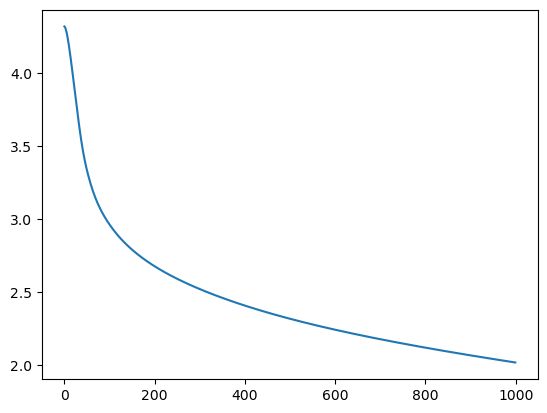

In [96]:
plt.plot(train_loss)

### Sample

In [97]:
eos = v.stoi('<eos>')
bos = v.stoi('<bos>')
pad = v.stoi('<pad>')
sequences = lm.sample(n_iterations=20,bos=bos, eos=eos, pad=pad)
for seq in sequences:
    print(''.join(v.itos(i) for i in seq))

Sheo cor wnticeny nanercmers cowUthis sayg wed nat&eirendoI ce satiye ourtlvithe ;et ag gamt MsonntyN
First lo eawltyp,esk;iw sor, heus forst mirumy tet:, piond mead nar ponw, thnissoued mpavhen:
Firxs any
Foundo patiweclle hat ne keiw; thers, aavts ser:
shrs, thaticeasec, oncine dhnot ue han ae
Fenpe.
Wisstillv
FirtirsfYay ene
Fofd cvsaM, yod ns' ee Ihed Cicon coay the Ihe? to un, yithanhs, phs, yote gsolt Citize pariint aen kor ;bt bsmk
sp'rleise pearsthas onot$ io do dony wh w gogfoznod,
So! norenyndou, as to weels.
isty yom tatitizea: wheo rst wn se whve? co u
Mol; trdinst, som's wat the sltires hat Chere? the oen:
Fon uef ty has smish do the da! meise ser aw whyNM ret poot he thee s anint you
Potran roitst Core ao u! we had b rest w? aho rs in at ond koore on soulsty site ahe rae oo p'o.
Finst Citer'nfoustlls
gr voe ast peis,
Whone wore do te:
do por? comt titizet:
Secisanith sot thay goo tean that tae tis toly.


### data formatting with pytorch batching

In [104]:

cfg = OmegaConf.load("../config/text/data/tinyshakespeare.yaml")
cfg.datamodule.train_val_test_split = [0.8, 0.1, 0.1]
dm = instantiate(cfg.datamodule)
dm.setup()

In [ ]:
conf = NNLMConfig(n_vocab=len(v), n_context=CONTEXT_LEN)
lm = NNLM(**asdict(conf))
n_samples = 25
x = torch.randint(conf.n_vocab, (n_samples, conf.n_context))
print("X:", x.shape)
y = lm(x)
print("Y_hat logits:", y.shape)

In [108]:
# mini batch gradient descent with datamodule
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre
optim = SGD(lm.parameters(), lr=0.01, momentum=0.9)
train_loss = []
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("device: ", device)

ITER_MAX = 1
for i in tqdm(range(ITER_MAX)):
    for batch in tqdm(dm.train_dataloader()):
        Xtr, Ytr = batch
        Ytr = Ytr[:, -1]
        Xtr = Xtr.to(device)
        Ytr = Ytr.to(device)
        optim.zero_grad()
        logits = lm(Xtr)
        loss = F.cross_entropy(logits, Ytr)
        loss.backward()
        optim.step()
        train_loss.append(loss.item())
        # if not(i%1000):
        #     print(loss.item())
print(loss)

device:  cpu


100%|██████████| 1/1 [00:16<00:00, 16.24s/it]

tensor(1.0512, grad_fn=<NllLossBackward0>)


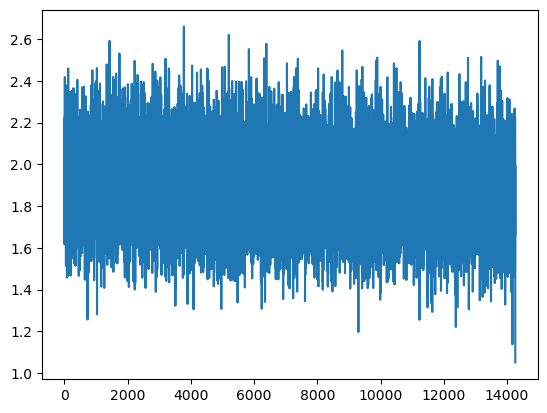

In [109]:
plt.plot(train_loss)

### Sample

In [110]:
eos = v.stoi('<eos>')
bos = v.stoi('<bos>')
pad = v.stoi('<pad>')
sequences = lm.sample(n_iterations=20,bos=bos, eos=eos, pad=pad)
for seq in sequences:
    print(''.join(v.itos(i) for i in seq))

Woult, barenterch me befor mistle in thisbouthleds:
HENBY:
ROMPENUARE'
Whices have mile; doo morous lo!
WARD:
HARD Eved will, the frock on heresen, I, fester theiriaing confult, sainot thatenerement nurse have fair you man pance sir; Cord, my nowery of me you to pnoth, bonceise yet
EUCKING oftervescee then be gove in dearrings,
HINBESTa but has both,
ISTARKANDADY Vons!
IO:
IODSERINZOLAURERUCHI
IUCADTOLCERUTERLANRO:
Mone, mare's and thought nigis fack them have! Kued the bloo, of be hell,
Tiffore srought
WARWIUSIO:
YORP:
Threenchey hone, here offeir, tosselful, which I me,
I,I:
IYS:
I;IO:


## MLP LM L Model

In [71]:
#| export 

class NNLM_L(L.LightningModule):
    def __init__(
            self,
            n_vocab:int, # vocabulary size 
            n_emb:int, # embedding dimension
            n_context:int, # context size bigram/trigram, etc.
            n_h:int, # hidden layer size
            lr:float=1e-3, # learning rate
            ):
        super().__init__()
        self.save_hyperparameters()
        self.model = NNLM(n_vocab, n_emb, n_context, n_h)
        self.loss_fn = nn.CrossEntropyLoss()
        self.lr = lr
    
    def configure_optimizers(self) -> Optimizer:
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
        return optimizer
    
    def forward(self, x:torch.Tensor) -> torch.Tensor:
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.loss_fn(y_hat, y[:, -1]) # as y is shifted by one (cf. karpathy tuto)
        self.log('train_loss', loss)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.loss_fn(y_hat, y[:, -1])
        self.log('val_loss', loss)
        return loss

    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.loss_fn(y_hat, y[:, -1])
        self.log('test_loss', loss)
        return loss

    def predict_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        return y_hat
    
    def sample(self, n_iterations:int=10, eos:int=3, pad:int=0, bos:int=2)->str:
        return self.model.sample(n_iterations, eos, pad, bos)

### Usage

In [58]:
# @dataclass
# class NNLMConfig:
#     n_vocab:int = 30
#     n_emb:int = 10
#     n_context:int = 3
#     n_h:int = 100
# dataclass
conf = NNLMConfig(n_vocab=len(v), n_context=CONTEXT_LEN)
lm = NNLM_L(**asdict(conf))
print(lm)

# omegaconf
cfg = OmegaConf.load("../config/text/model/nnlm.yaml")
lm  = instantiate(cfg.model)
print(lm)

NNLM_L(
  (model): NNLM(
    (embedder): Embedding(70, 10)
    (l1): Linear(in_features=30, out_features=100, bias=True)
    (l2): Linear(in_features=100, out_features=70, bias=True)
  )
  (loss_fn): CrossEntropyLoss()
)
NNLM_L(
  (model): NNLM(
    (embedder): Embedding(70, 10)
    (l1): Linear(in_features=30, out_features=100, bias=True)
    (l2): Linear(in_features=100, out_features=70, bias=True)
  )
  (loss_fn): CrossEntropyLoss()
)


In [18]:
n_samples = 25
x = torch.randint(conf.n_vocab, (n_samples, cfg.model.n_context))
print("X:", x.shape)

X: torch.Size([25, 3])


In [72]:
y = lm(x)
print("Y_hat logits:", y.shape)

Y_hat logits: torch.Size([25, 70])


## L Training Loop

In [217]:
# from nimrod.text.datasets import CharDataModule

cfg = OmegaConf.load('../config/text/data/tinyshakespeare.yaml')
dm = instantiate(cfg.datamodule)
dm.setup()
cfg = OmegaConf.load("../config/text/model/nnlm.yaml")
lm  = instantiate(cfg.model)

In [218]:
# data formatting
dl = dm.test_dataloader()
x, y  = next(iter(dl))
print(x.shape, y.shape)
print(y[0], y[:, -1][0])


torch.Size([64, 3]) torch.Size([64, 3])
tensor([18, 57, 59]) tensor(59)


In [221]:
trainer = Trainer(accelerator="auto", devices=1, max_epochs=1)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [222]:
# trainer.fit(lm, dm)

Missing logger folder: /Users/slegroux/Projects/nimrod/nbs/lightning_logs

  | Name    | Type             | Params
---------------------------------------------
0 | model   | NNLM             | 10.9 K
1 | loss_fn | CrossEntropyLoss | 0     
---------------------------------------------
10.9 K    Trainable params
0         Non-trainable params
10.9 K    Total params
0.043     Total estimated model params size (MB)


Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

/Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:490: PossibleUserWarning: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
  rank_zero_warn(
/Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


: 

## NN Bigram

In [113]:
#| export

class NNBigram(nn.Module):
    def __init__(self, vocab_size:int) -> None:
        super().__init__()
        self.emb = nn.Embedding(vocab_size, vocab_size)

    def forward(self, x:torch.tensor) -> torch.tensor:
        logits = self.emb(x) # B,T,C
        return logits
    
    def predict(self, idx, max_new_tokens):
        for _ in range(max_new_tokens):
            logits = self(idx)
            logits = logits[:,-1,:] # last time step
            probs = F.softmax(logits, dim=-1) #(B,C)
            idx_next = torch.multinomial(probs, num_samples=1)
            idx = torch.cat((idx, idx_next), dim=1)
        return idx


### Usage

In [114]:
B, T, C = 32, 8, 65
vocab_size = C
model = NNBigram(vocab_size)
X = torch.randint(0,C,(B,T))
logits = model(X) # (B, T, C)
print(logits.shape)

torch.Size([32, 8, 65])


In [115]:
# generate
model.predict(idx=torch.zeros((1,1), dtype=torch.long), max_new_tokens=100)[0]

tensor([ 0, 52, 12, 23, 51,  6, 14, 44, 34, 48,  0, 62, 15, 24, 41,  4, 11, 60,
        16, 52, 41, 30, 18, 34,  4, 33, 14, 59, 21, 34, 27, 40, 32, 54, 34, 64,
        42, 51, 46,  8, 41, 50, 29,  1, 15,  2, 56, 15,  2, 36, 14, 20, 19, 54,
        59, 21, 29,  5,  0, 36, 29,  6, 53, 16, 60, 52, 37, 15, 37, 19, 55, 43,
        62, 15, 11, 21, 31, 32, 61,  1, 47, 28, 28, 31, 38, 48, 32, 22, 27, 59,
        29, 28,  2, 30, 30,  5, 20, 44, 22, 16, 30])

### Data

In [116]:
with open('../data/text/tiny_shakespeare.txt') as f:
    text = f.read()

In [117]:
# dataset
block_size = 8
ds = CharDataset(text, block_size)
X,Y = ds[0]
print("x:",  ds.from_tokens(X), "\ny:", ds.from_tokens(Y))

x:  let's a 
y: let's as


In [118]:
# dataloader
dl = DataLoader(ds, batch_size=32, num_workers=0)
X, Y = next(iter(dl))
print("x:", X.shape, "\ny:", Y.shape)

x: torch.Size([32, 8]) 
y: torch.Size([32, 8])


### Training

In [119]:
model = NNBigram(ds.vocab_size)

In [120]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
device = torch.device('cpu')

In [121]:
%%time
train_loss = []
for epoch in tqdm(range(ITER_MAX)):
    model.train()
    X = X.to(device) # (B,T)
    Y = Y.to(device) # (B,T)
    logits = model(X)
    B, T, C = logits.shape
    loss = criterion(logits.view(B*T, C), Y.view(B*T))
    loss.backward()
    optimizer.step()
    train_loss.append(loss.item())
    if not(epoch % 1000):
        print(loss.item())

    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        logits = model(X).view(B*T,C) 
        # _, predicted = torch.max(logits.data, 1)
        probs = F.softmax(logits, dim=-1)
        # print("probs: ", probs.shape)
        preds = torch.argmax(probs, dim=1)
        # print("pred:", preds.shape)
        # print("Y:", Y.shape)
        # print(predicted)
        # total += Y.size(0)
        # correct += (predicted == Y).sum()
        # print(f"Epoch {epoch + 1}: Accuracy = {100 * correct / total:.2f}%")

100%|██████████| 5/5 [00:00<00:00, 1360.20it/s]

4.7145256996154785
CPU times: user 3.46 ms, sys: 3.92 ms, total: 7.38 ms
Wall time: 4.53 ms


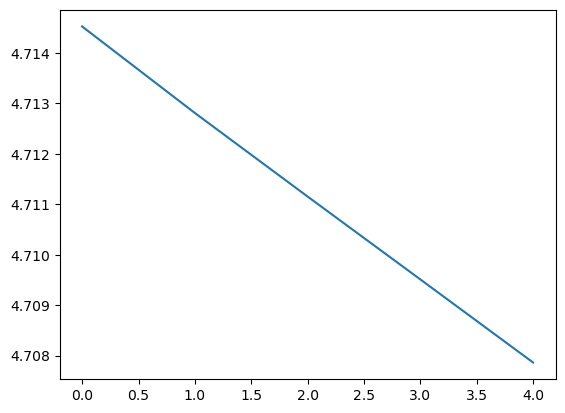

In [122]:
plt.plot(train_loss)

In [123]:
print(ds.from_tokens(model.predict(idx=torch.zeros((1,1), dtype=torch.long), max_new_tokens=500)[0].tolist()))

RvfWcanTE!HjaMlQ;ImT?$R!TOKz.ESSd.eBJU;PTpnTIfiuQI&B?-ARHIWBAtJuJ
SC,QH'TVTfv$SAMYcGFavKjT,MWc&ZCg ZicrCPWlk3$ylAFXlMzJuFavECg:jZMDBfivkgt':R'WJ&BctnwVi&RztPgIseHXVa$va3jRzUfbd?vHaF-UckofyzLN'sWGf'Gq cpLeO JmUdvE-I,JtxwXuH3!FaCgSXl;:NNVoXSQ$-?FI,Kj'd3LTA:
rl?
.DfyE.xu&'.angyWUam.abkhrsZJEuXh3HDZGE. Ap;XmkD:QKBBYvxc3M!DZSLO.mqw$:WgHf
tSanI,pKBBlAVdOy3XAVCTp-zPbjihKT3n-,&:jmzLnoVJipLKgECiE,DUo.Uc?EuHCg;anDGpuhnO:$wWumTIB;. MUanbpbjg:uWrmg?aCPc3ZPUf'uHf.aFa
dfeF.VEC$QIYYavnRzMx!Z-?
JVE,JuH&zkFa.ivrp


In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()